# Evaluate model for Vietnamese Stock Env

In [1]:
import os
from pathlib import Path
path = Path(os.getcwd())
os.chdir(path.parent.absolute())

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import pandas_ta as ta
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import mt4_hst
import vectorbt as vbt

import stock_env
from stock_env.utils import create_performance, plot_trade_log_v2
from stock_env.envs import RandomStockEnv
from stock_env.feature.feature_extractor import TrendFeatures
from stock_env.wrappers.stack_obs import StackObs
from stock_env.data_loader import RandomStockLoader

In [2]:
# settings
path = "../stock_datasets/"
init_cash = 20e3
feature_extractor = TrendFeatures
model = PPO.load("log/best_model.zip")
# model = PPO.load("log/PPO_RandomStockEnv_TrendFeatures_finservice.zip")

# Evaluation

## Evaluation on random period

In [3]:
tickers = "HAH HPG VHC VIC PNJ".split()
data_loader = RandomStockLoader(
    tickers = tickers,
    data_folder_path = path,
    feature_extractor = feature_extractor
)

env = RandomStockEnv(data_loader)
env = StackObs(env, 5)

mean, std = evaluate_policy(model, env, n_eval_episodes=100)
print(f"Mean reward: {mean:.2f} +/- {std: .2f}")

Mean reward: -97.22 +/-  349.24


# Evaluation on specific stock

In [16]:
tickers = "HPG".split()
data_loader = RandomStockLoader(
    tickers = tickers,
    data_folder_path = path,
    feature_extractor = feature_extractor
)
data_loader.train(False)
env = RandomStockEnv(data_loader)
env = StackObs(env, 5)

In [17]:
# run model to get detailed information in the enviroment
done = False
obs = env.reset()
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, _, done, _ = env.step(action)

# get data
df = env.get_history()
df.sort_values(by='time', inplace=True)
df.index = pd.to_datetime(df['time'])


    Annual return     :  10.32%
    Cumulative return :  310.79%
    Sharpe ratio      :  0.63
    Maximum Drawdown  : -46.57%
    Annual Volatility :  18.41%
    Value-At-Risk     :  nan%
    


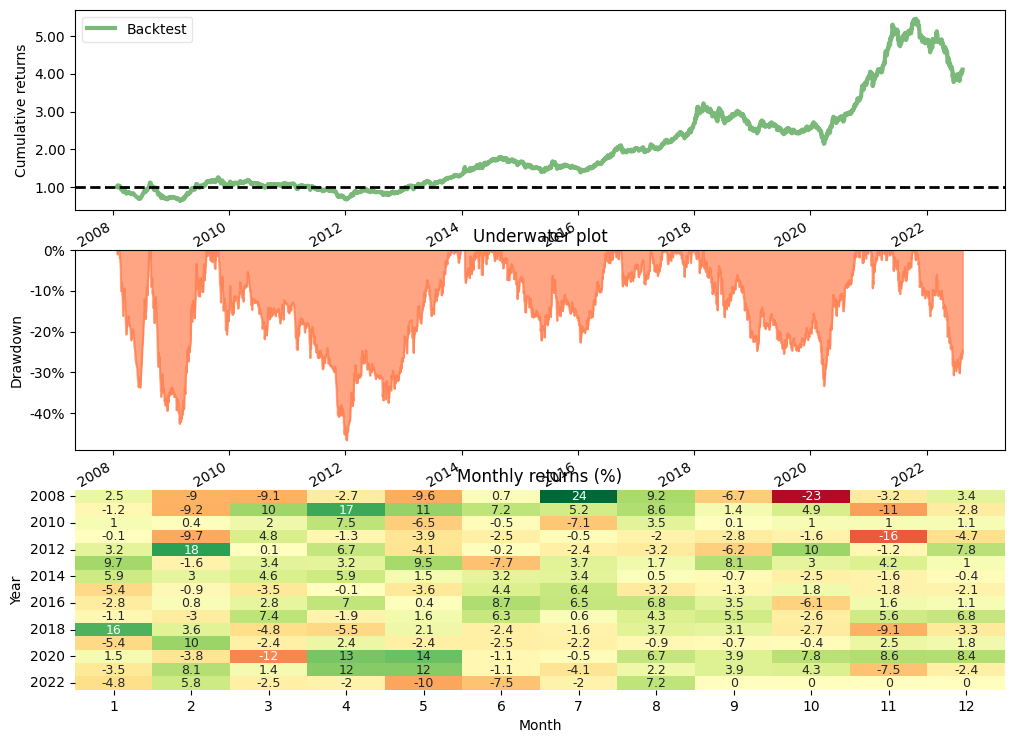

In [18]:
create_performance(df['portfolio_value'].pct_change())

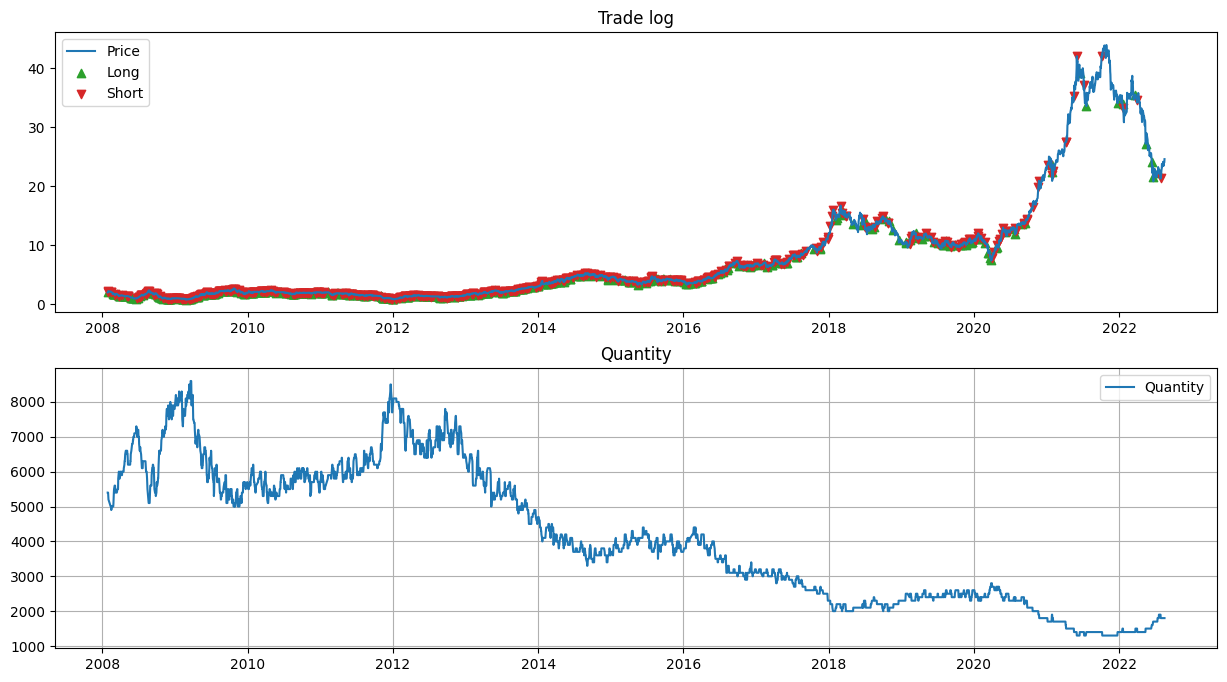

In [19]:
plot_trade_log_v2(df)

# Compare with buy-and-hold strategy and feature strategy

In [20]:
# portfolio value from hodling
df['pv_from_holding'] = vbt.Portfolio.from_holding(df.close, init_cash=20e3).value()

strategy_signals = df.ta.tsignals(df['TS_Trends'].fillna(0))
df['pv_from_strategy'] = vbt.Portfolio.from_signals(
    df.close, 
    entries=strategy_signals.TS_Entries, 
    exits=strategy_signals.TS_Exits,
    init_cash=20e3).value()

In [21]:
fig = df['portfolio_value'].vbt.plot_against(df['pv_from_holding'])
df['pv_from_strategy'].vbt.plot_against(df['pv_from_holding'], fig=fig)

FigureWidget({
    'data': [{'hoverinfo': 'skip',
              'line': {'color': 'rgba(0, 0, 0, 0)', 'width':…